# Hillstrom dataset

In [1]:
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [2]:
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from causalml.inference.meta import BaseXRegressor, BaseRClassifier, BaseSClassifier, BaseTClassifier
from causalml.dataset import *
from causalml.metrics import *

plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
df = pd.read_csv('Hillstrom.csv')
df.drop(['history_segment', "conversion", "spend"], axis=1, inplace=True)

cat_cols = ['zip_code', 'channel']
df_ohe = pd.get_dummies(df, columns=cat_cols)
df_ohe.segment = df_ohe.segment.map({'Womens E-Mail': 1, 'Mens E-Mail': 1, 'No E-Mail': 0})

X = df_ohe.drop('visit', axis=1)
y = df_ohe['visit'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

treat_train = X_train['segment']
treat_test = X_test['segment']

X_train.drop(['segment'], axis=1, inplace=True)
X_test.drop(['segment'], axis=1, inplace=True)

# ATE

In [4]:
def get_mean_target(treatment_flg):
    return df_ohe[df_ohe['segment']==treatment_flg]['visit'].mean()

get_mean_target(1) - get_mean_target(0)

0.06088195726098464

# Double machine learning

In [5]:
from econml.dml import LinearDMLCateEstimator
from lightgbm import LGBMClassifier

est = LinearDMLCateEstimator(model_y=LGBMClassifier(max_depth=5), 
                             model_t=LGBMClassifier(max_depth=5),
                             discrete_treatment=True)
est.fit(y_train, treat_train, X_train)
uplift = est.const_marginal_effect(X_test)[:, 0]
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Uplift at 30: 0.06621646211330146


In [6]:
from econml.dml import NonParamDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

est = NonParamDMLCateEstimator(model_y=LGBMRegressor(),
                               model_t=LGBMRegressor(),
                               model_final=LGBMRegressor())
est.fit(y_train, treat_train, X_train)
uplift = est.effect(X_test.values)
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

Uplift at 30: 0.062120697271015865


# Meta Learners

## T-learner

In [7]:
#econml
from econml.metalearners import TLearner

est = TLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# T Learner
learner_t = BaseTClassifier(learner=LGBMClassifier())
learner_t.fit(X=X_train, treatment=treat_train, y=y_train)
cate_t = np.squeeze(learner_t.predict(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=cate_t, treatment=treat_test, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

#sklift
from sklift.models import TwoModels
tm = TwoModels(estimator_trmnt=LGBMClassifier(), estimator_ctrl=LGBMClassifier(), method='vanilla')
tm = tm.fit(X_train, y_train, treat_train)
uplift_tm = tm.predict(X_test.values)
score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.07447698924023219
causalml	| Uplift at 30: 0.06102530650309912
sklift		| Uplift at 30: 0.06102530650309912


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=-0.0028'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

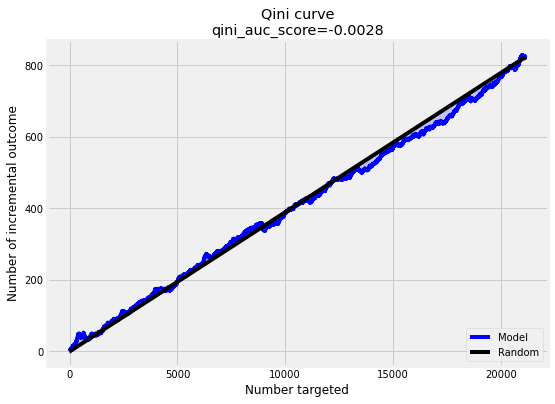

In [8]:
plot_qini_curve(y_true=y_test, uplift=cate_t, treatment=treat_test, negative_effect=True, perfect=False)

## S-learner

In [9]:
#econml
from econml.metalearners import SLearner

est = SLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")


#causalml
# S Learner
learner_s = BaseSClassifier(learner=LGBMClassifier())
learner_s.fit(X=X_train, treatment=treat_train, y=y_train)
cate_s = np.squeeze(learner_s.predict(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=cate_s, treatment=treat_test, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")


#sklift
from sklift.models import SoloModel

sm = SoloModel(LGBMClassifier())
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test.values)
score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.07399829129863333
causalml	| Uplift at 30: 0.06677734818476973
sklift		| Uplift at 30: 0.06677734818476973


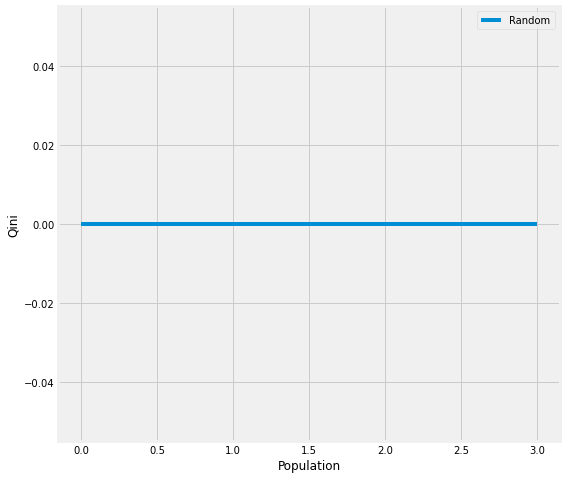

In [10]:
plot_qini(pd.DataFrame([y_test, uplift, treat_test], columns =['y_test', 'uplift', 'treat_test']), 'y_test', 'treat_test', 'uplift')

In [11]:
# plot_qini_curve(y_true=y_test, uplift=uplift, treatment=treat_test, negative_effect=True, perfect=False)
# plot_qini_curve(y_true=y_test, uplift=cate_s, treatment=treat_test, negative_effect=True, perfect=False)
# plot_qini_curve(y_true=y_test, uplift=uplift_sm, treatment=treat_test, negative_effect=True, perfect=False)

## X-Learner

In [12]:
#econml
from econml.metalearners import XLearner

est = XLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# X Learner
learner_x = BaseXRegressor(learner=LGBMClassifier())
learner_x.fit(X=X_train, treatment=treat_train, y=y_train)
cate_x = np.squeeze(learner_x.predict(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=cate_x, treatment=treat_test, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.07305622818040441
causalml	| Uplift at 30: 0.07305622818040441


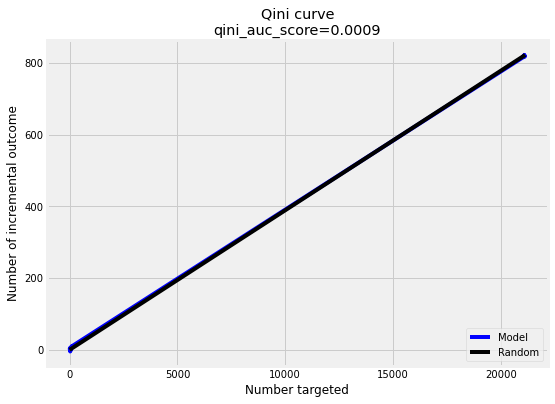

In [13]:
plot_qini_curve(y_true=y_test, uplift=cate_x, treatment=treat_test, perfect=False);